In [1]:
from PIL import Image
import numpy as np
import os
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.measure import label
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy.ndimage.measurements import center_of_mass


In [132]:
def find_centers_and_crop (image_id, scale=1, cropsize=128):
    imagepath = os.path.join('/kaggle2/hpaic/train', f"{image_id}_blue.png")
    
    # Get the image and resize
    color_image = np.array(Image.open(imagepath))
    print ("Working on", imagepath)
    image_shape = color_image.shape[:2]
    image_shape = tuple(ti//scale for ti in image_shape)
    color_image = resize(color_image, image_shape)

    # Split the image into channels
    #microtubules = color_image[:, :, 0]
    #antibody = color_image[:, :, 1]
    nuclei = color_image[:, :]

    # Segment the nuclear channel and get the nuclei
    min_nuc_size = 100.0

    val = threshold_otsu(nuclei)
    smoothed_nuclei = gaussian(nuclei, sigma=5.0)
    binary_nuclei = smoothed_nuclei > val
    binary_nuclei = remove_small_holes(binary_nuclei, min_size=300)
    labeled_nuclei = label(binary_nuclei)
    labeled_nuclei = clear_border(labeled_nuclei)
    labeled_nuclei = remove_small_objects(labeled_nuclei, min_size=min_nuc_size)
    
    cells = []
    crops = []

    # Iterate through each nuclei and get their centers (if the object is valid), and save to directory
    for i in range(1, np.max(labeled_nuclei)):
        current_nuc = labeled_nuclei == i
        if np.sum(current_nuc) > min_nuc_size:
            y, x = center_of_mass(current_nuc)
            x = np.int(x)
            y = np.int(y)

            c1 = y - cropsize // 2
            c2 = y + cropsize // 2
            c3 = x - cropsize // 2
            c4 = x + cropsize // 2

            if c1 < 0 or c3 < 0 or c2 > image_shape[0] or c4 > image_shape[1]:
                pass
            else:
                cells.append([c1, c2, c3, c4])
                nuclei_crop = nuclei[c1:c2, c3:c4]
                crops.append(nuclei_crop)
                #antibody_crop = antibody[c1:c2, c3:c4]
                #microtubule_crop = microtubules[c1:c2, c3:c4]
    return color_image, cells, crops, labeled_nuclei


In [192]:
image_id = "00c58890-bbbc-11e8-b2ba-ac1f6b6435d0"
img, cells, crops, labeled_nuclei = find_centers_and_crop(image_id)

Working on /kaggle2/hpaic/train/00c58890-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png


In [193]:
import matplotlib.pyplot as plt

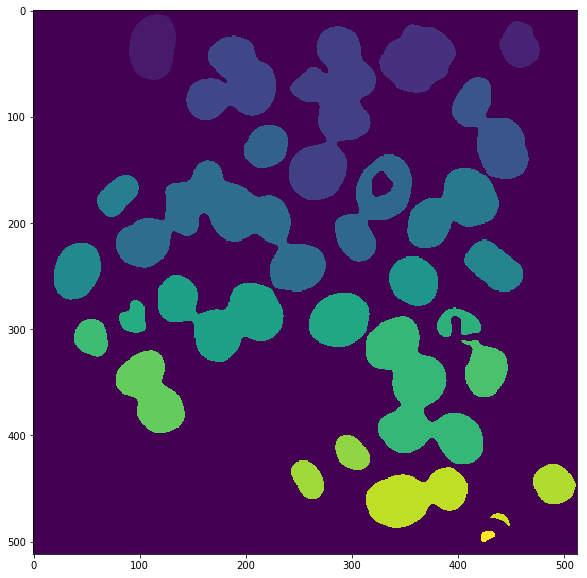

In [194]:
plt.figure(figsize=(10, 10))
plt.imshow(labeled_nuclei)

In [195]:
def load_rby(image_id):
    kinds = ['red', 'blue', 'yellow']
    img = np.zeros((512, 512, len(kinds)), np.uint8)
    flags = cv2.IMREAD_GRAYSCALE
    for idx, kind in enumerate(kinds):
        path = os.path.join('/kaggle2/hpaic/train', f"{image_id}_{kind}.png")
        img[:, :, idx] = cv2.imread(str(path), flags)
    return img

def load_rby_masked(image_id):
    kinds = ['red', 'blue', 'yellow']    
    img = np.zeros((512, 512, len(kinds)), np.uint8)
    flags = cv2.IMREAD_GRAYSCALE
    mask = cv2.imread(os.path.join('/kaggle2/hpaic/train', f"{image_id}_green.png"), flags)
    for idx, kind in enumerate(kinds):
        path = os.path.join('/kaggle2/hpaic/train', f"{image_id}_{kind}.png")
        img[:, :, idx] = cv2.bitwise_and(cv2.imread(str(path), flags), mask)
    return img

def load_green(image_id, kind='green'):
    path = os.path.join('/kaggle2/hpaic/train', f"{image_id}_{kind}.png")
    flags = cv2.IMREAD_GRAYSCALE
    return cv2.imread(str(path), flags)
    

In [196]:
rby = load_rby(image_id)
rby_masked = load_rby_masked(image_id)

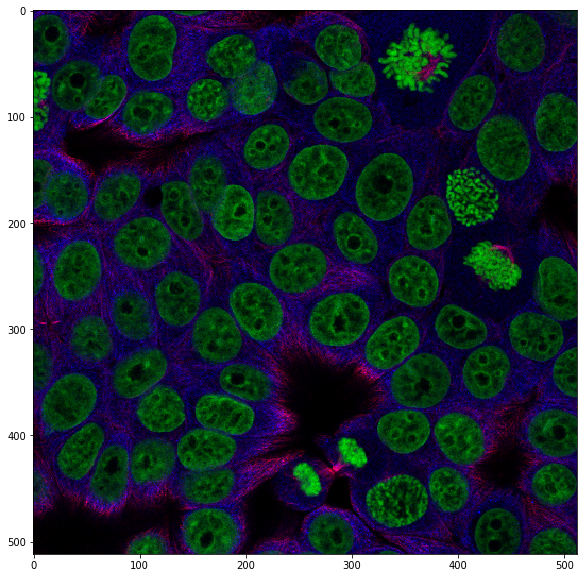

In [197]:
plt.figure(figsize=(10, 10))
plt.imshow(rby)

In [198]:
green = load_green(image_id)

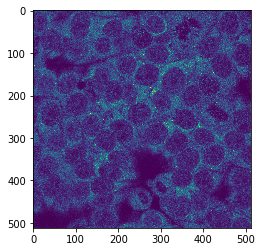

In [199]:
plt.imshow(green)

In [200]:
rby.shape, green.shape
for ch in range(3):
    x1 = rby[:, :, ch]
    x2 = green
    print(ch, np.sum(cv2.bitwise_and((x1>0).astype(np.uint8), (x2>0).astype(np.uint8))))
    

0 198285
1 134378
2 255205


In [201]:
np.sum((green>0).astype(np.uint8))
#cv2.bitwise_and(labeled_nuclei, x2)

258365

In [202]:
np.sum(cv2.bitwise_and((labeled_nuclei>0).astype(np.uint8), (x2>0).astype(np.uint8)))

75055

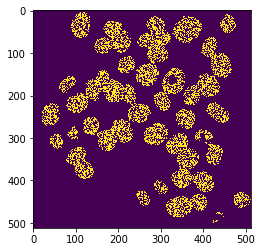

In [203]:
plt.imshow(cv2.bitwise_and((labeled_nuclei>0).astype(np.uint8), x2))

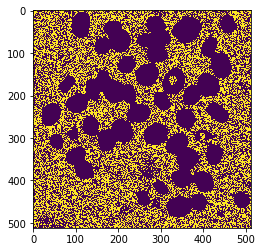

In [204]:
plt.imshow(cv2.bitwise_and((labeled_nuclei==0).astype(np.uint8), x2))

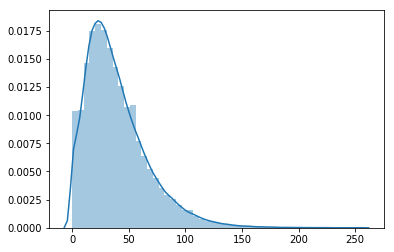

In [205]:
import seaborn as sns
sns.distplot(green.reshape(-1))